In [1]:
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
from scipy.signal import windows as wd

try:
    import mkl_fft  # a faster fft
except:
    mkl_fft = np.fft  # otherwise just use numpy's fft


In [2]:
def fft(x, axis=None):
    """
    calculates the 1D fft of the numpy array x
    if x is not 1D you need to specify the axis
    """

    if axis is None:
        return np.fft.fftshift(mkl_fft.fft(np.fft.ifftshift(x)))
    else:
        return np.fft.fftshift(mkl_fft.fft(np.fft.ifftshift(x, axes=axis), axis=axis), axes=axis)


def ifft(x, axis=None):
    """
    calculates the 1D ifft of the numpy array x
    if x is not 1D you need to specify the axis
    """

    if axis is None:
        return np.fft.fftshift(mkl_fft.ifft(np.fft.ifftshift(x)))
    else:
        return np.fft.fftshift(mkl_fft.ifft(np.fft.ifftshift(x, axes=axis), axis=axis), axes=axis)


def normalize(vec):
    return vec / np.max(abs(vec))


# useful for plotting in order to determine good apodization window
# and frequency window to fit spectral phase
def get_phase(dat, N_apod, plot=True, ax=None, ax2=None):
    ppifg = len(dat)
    center = ppifg // 2
    ft = fft(dat[center - N_apod // 2: center + N_apod // 2])
    phase = np.unwrap(np.arctan2(ft.imag, ft.real))
    freq = np.fft.fftshift(np.fft.fftfreq(len(phase)))

    if plot:
        if ax is None:
            fig, ax = plt.subplots(1, 1)
        if ax2 is None:
            ax2 = ax.twinx()
        ax.plot(freq, phase, '.-')
        ax2.plot(freq, ft.__abs__(), '.-', color='k')
    return freq, phase, ft.__abs__(), ax, ax2


# modifies the ft array in place
def apply_t0_shift(pdiff, freq, ft):
    # the polynomial fits the spectral phase in radians,
    # so the factor of 2 pi is already there
    ft[:] *= np.exp(1j * freq * pdiff[:, 0][:, np.newaxis])


# modifies the hbt array in place
def apply_phi0_shift(pdiff, hbt):
    # the polynomial fits the spectral phase in radians,
    # so the factor of 2 pi is already there
    hbt[:] *= np.exp(1j * pdiff[:, 1][:, np.newaxis])


def get_pdiff(data, ll_freq, ul_freq, Nzoom=200):
    """
    :param data: 2D array of IFG's, row column order
    :param ppifg: int, length of each interferogram
    :param ll_freq: lower frequency limit for spectral phase fit, given on -.5 to .5 scale
    :param ul_freq: upper frequency limit for spectral phase fit, given on -.5 to .5 scale
    :param Nzoom: the apodization window for the IFG, don't worry about f0 since you are fitting the spectral phase,
    not doing a cross-correlation, you need to apodize or else your SNR isn't good enough to have a good fit, so
    plot it first before specifying this parameter, generally 200 is pretty good
    :return: pdiff, polynomial coefficients, higher order first
    """

    center = len(data[0]) // 2
    zoom = data[:, center - Nzoom // 2:center + Nzoom // 2]
    zoom = (zoom.T - np.mean(zoom, 1)).T

    # not fftshifted
    ft = fft(zoom, 1)
    freq = np.fft.fftshift(np.fft.fftfreq(len(ft[0])))
    ll, ul = np.argmin(abs(freq - ll_freq)), np.argmin(abs(freq - ul_freq))

    phase = np.unwrap(np.arctan2(ft.imag, ft.real))
    phase = phase.T  # column order for polynomial fitting
    p = np.polyfit(freq[ll:ul], phase[ll:ul], 1).T
    pdiff = p[0] - p

    return pdiff


# modifies the data array in place
def apply_t0_and_phi0_shift(pdiff, data):
    freq = np.fft.fftshift(np.fft.fftfreq(len(data[0])))
    ft = fft(data, 1)
    apply_t0_shift(pdiff, freq, ft)
    td = ifft(ft, 1).real

    # td is the linear phase corrected time domain data
    hbt = ss.hilbert(td)  # take hilbert transform of the linear phase corrected time domain data
    apply_phi0_shift(pdiff, hbt)  # multiply by constant phase offset
    hbt = hbt.real  # just take the real (no inverse)

    data[:] = hbt.real


In [3]:
def shift_2d(data, shifts):
    ft = mkl_fft.fft(np.fft.ifftshift(data, axes=1), axis=1)  # fftshifted
    freq = np.fft.fftfreq(len(ft[0]))
    phase = np.zeros(data.shape).astype(np.complex128)
    phase[:] = 1j * 2 * np.pi * freq
    phase = (phase.T * shifts).T
    phase = np.exp(phase)
    ft *= phase
    ft = np.fft.fftshift(mkl_fft.ifft(ft, axis=1), axes=1)
    phase_corr = ft.real
    return phase_corr


def t0_correct_via_cross_corr(data, N_zoom=50, plot=True):
    """
    :param data: data as a 2D array
    :param ppifg: points per interferogram
    :param N_zoom: number of data points in the zoomed in window from calculating the phase correction
    :param plot: plot the phase correction (diagnostics)

    :return: phase corrected data as a 2D array
    """
    center = len(data[0]) // 2

    # zoomed in data
    zoom = data[:, center - (N_zoom + 0): center + (N_zoom + 1)].astype(float)
    zoom = (zoom.T - np.mean(zoom, 1)).T

    # appodize to remove f0, use a window of size 50
    window = wd.blackman(N_zoom)
    left = (len(zoom[0]) - N_zoom) // 2
    right = len(zoom[0]) - N_zoom - left
    window = np.pad(window, (left, right), constant_values=0)

    WINDOWS = np.zeros(zoom.shape)
    for n, i in enumerate(zoom):
        ind = np.argmax(abs(i) ** 2)
        roll = ind - len(zoom[0]) // 2
        WINDOWS[n] = np.roll(window, roll)

    zoom_appod = zoom * WINDOWS

    # calculate the shifts
    fft_zoom = fft(zoom_appod, 1)
    ref = fft_zoom[0]
    fft_zoom *= np.conj(ref)
    fft_zoom = np.pad(fft_zoom, ([0, 0], [2 ** 10, 2 ** 10]), constant_values=0.0)
    fft_zoom = ifft(fft_zoom, 1)
    ind = np.argmax(fft_zoom, axis=1) - len(fft_zoom[0]) // 2
    shift = ind * len(zoom[0]) / len(fft_zoom[0])

    # shift correct data
    phase_corr = shift_2d(data, shift)

    if plot:
        # a view of the appodization method for removal of f0
        fig, ax = plt.subplots(1, 2, figsize=np.array([11.9, 4.8]))
        ax[0].plot(normalize(zoom[0]))
        ax[0].plot(WINDOWS[0])
        ax[1].plot(normalize(zoom_appod[0]))

        # check the phase correction
        fig, ax = plt.subplots(1, 2, figsize=np.array([11.9, 4.8]))
        [ax[1].plot(i[center - 100:center + 100]) for i in phase_corr[:50]]
        [ax[1].plot(i[center - 100:center + 100]) for i in phase_corr[-50:]]
        [ax[0].plot(i[center - 100:center + 100]) for i in data[:50]]
        [ax[0].plot(i[center - 100:center + 100]) for i in data[-50:]]
        ax[0].set_title("un corrected")
        ax[1].set_title("corrected")

    return phase_corr, shift

## Phase fitting doesn't seem to work well??

In [4]:
path = r"/home/peterchang/Downloads/"
data = np.genfromtxt(path + "Data.txt")
T = np.genfromtxt(path + "t_axis.txt")
N = np.arange(-len(data[0]) // 2, len(data[0]) // 2)
ppifg = len(N)
center = ppifg // 2


### Picking an apodization window, and a section of the spectrum to fit the phase from

In [5]:
apod = 5000


(0.18, 0.225)

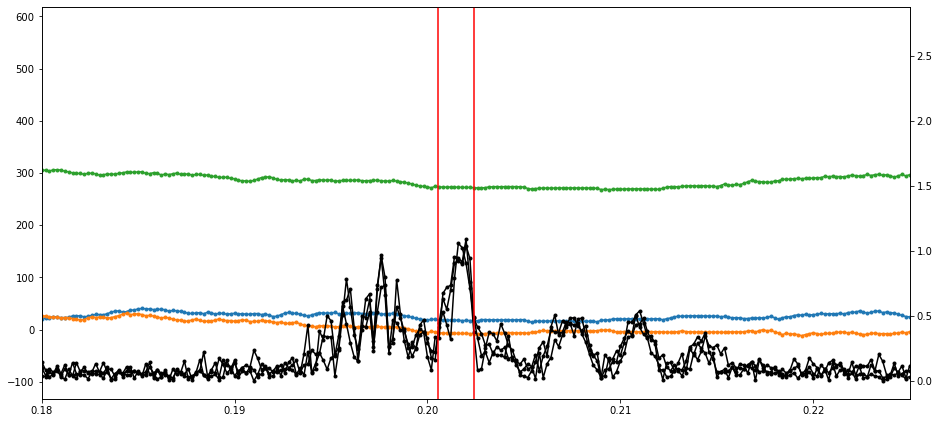

In [6]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=np.array([15.55555556, 7.20833333]))

f, p, a, ax, ax2 = get_phase(data[np.random.randint(0, len(data))], apod, ax=ax, ax2=None)
get_phase(data[np.random.randint(0, len(data))], apod, ax=ax, ax2=ax2)
get_phase(data[np.random.randint(0, len(data))], apod, ax=ax, ax2=ax2)

ll, ul = .200526, .202436

plt.axvline(ll, color='r')
plt.axvline(ul, color='r')
ax.set_xlim(.18, .225)

In [7]:
pdiff = get_pdiff(data, ll, ul, apod)
apply_t0_and_phi0_shift(pdiff, data)


(13500.0, 16500.0)

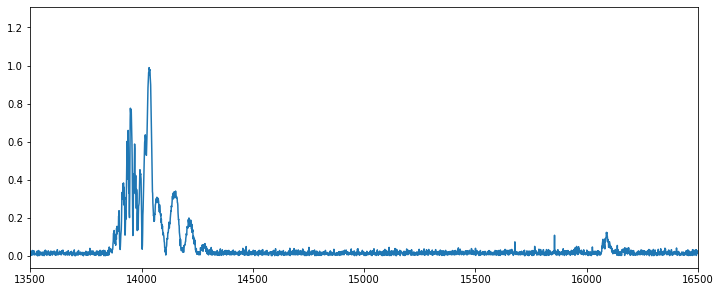

In [8]:
fig, ax = plt.subplots(1, 1, figsize=np.array([11.97, 4.8]))
avg = np.mean(data, axis=0)
ft = fft(avg)
ax.plot(abs(ft))
ax.set_xlim(13500, 16500)

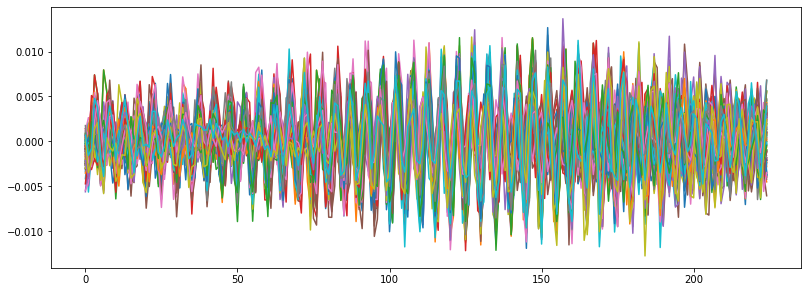

In [9]:
fig, ax = plt.subplots(1, 1, figsize=np.array([13.43, 4.8]))
for i in data:
    ax.plot(i[center - 150 // 2:center + 300 // 2])

### I noticed that it sort of just maximizes the peak of the spectrum that I chose to fit the phase from. As you can see in the time domain, the interferograms are lined up kind of in a weird way...

## Simply cross-correlation in time domain (maximizing overlap integral) seems to work better??

In [10]:
path = r"/home/peterchang/Downloads/"
data = np.genfromtxt(path + "Data.txt")
T = np.genfromtxt(path + "t_axis.txt")
N = np.arange(-len(data[0]) // 2, len(data[0]) // 2)
ppifg = len(N)
center = ppifg // 2

In [11]:
data = (data.T - np.mean(data, axis=1)).T
data, shift = t0_correct_via_cross_corr(data, 5000, False)

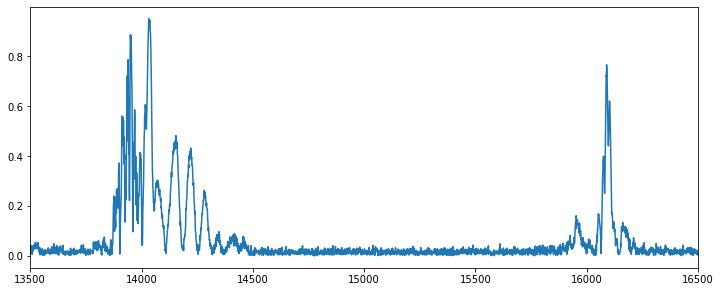

In [12]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=np.array([11.97, 4.8]))
avg_2 = np.mean(data, axis=0)
ax.set_xlim(13500, 16500)
ft = fft(avg_2)
ax.plot(abs(ft))

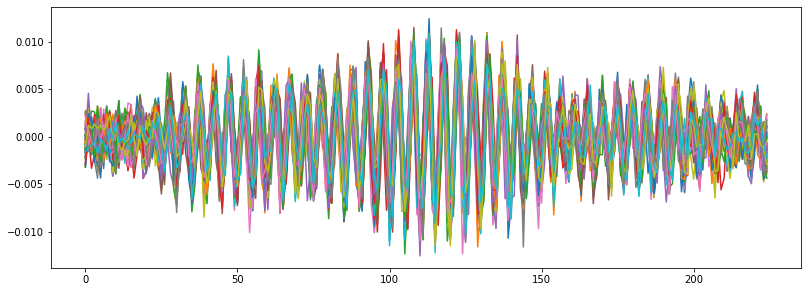

In [13]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=np.array([13.43, 4.8]))
for i in data:
    ax.plot(i[center - 150 // 2:center + 300 // 2])

### As you can see from the above, simply calculating an optimal time shift by using a cross-correlation will line up the interferograms pretty well by eye... The SNR this way seems to be better. It bypasses the issue of choosing which lobe of the spectrum to fit the phase from. This is only a time shift correction (phase slope), there is no phase offset correction...